In [1]:
from EnsembleFramework import Framework

In [184]:
import torch
from torch import nn
from torch_geometric.nn import GATConv

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_3 = nn.Linear(hidden_dim, output_dim)
        self.layer_1 = GATConv(input_dim, hidden_dim, heads= 4, dropout=0.0)
        self.layer_2 = GATConv(hidden_dim, hidden_dim, heads= 4, dropout=0.0)
        self.layer_3 = GATConv(hidden_dim, output_dim, heads= 6, dropout=0.0)

    def forward(self, x):
        x = self.layer_1(x)
        x = nn.functional.elu(x)
        x = self.layer_2(x)
        x = nn.functional.elu(x)
        x = self.layer_3(x)
        # x = nn.functional.sigmoid(x)
        return x

In [185]:
from torch_geometric.datasets import PPI
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from torch_geometric.loader import DataLoader

train_dataset = PPI(root='/tmp/PPI', split="train")
val_dataset = PPI(root='/tmp/PPI', split="val")
test_dataset = PPI(root='/tmp/PPI', split="test")
train_dataset.transform = T.NormalizeFeatures()
val_dataset.transform = T.NormalizeFeatures()
test_dataset.transform = T.NormalizeFeatures()

train_loader = iter(DataLoader(train_dataset, batch_size=len(train_dataset)))
val_loader = iter(DataLoader(val_dataset, batch_size=len(val_dataset)))
test_loader = iter(DataLoader(test_dataset, batch_size=len(test_dataset)))

train_data = next(train_loader)
val_data = next(val_loader)
test_data = next(test_loader)

In [186]:
X_train = train_data.x
y_train = train_data.y

X_test = test_data.x
y_test = test_data.y

In [187]:
device = torch.device("cuda:0")

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [209]:
def train(model, X_train, y_train):
    global epochs, loss_fn, opt
    for epoch in range(epochs):
        model.train()
        out = model(X_train)
        loss = loss_fn(out, y_train)
        train_losses.append(loss.sum().item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    return model

In [210]:
def evaluate(model, X_test, y_test):
    with torch.inference_mode():
        model.eval()
        logits = model(X_test)
        loss = loss_fn(logits, y_test)
        print(loss)

In [233]:
model = Model(X_train.shape[1], 256, y_train.shape[1]).to(device)
learning_rate = 5e-3
epochs = 100
opt = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

train_losses = []

In [234]:
X_train.shape

torch.Size([44906, 50])

In [235]:
evaluate(model, X_train, y_train)

tensor(0.6945, device='cuda:0')


In [236]:
model = train(model, X_train, y_train)

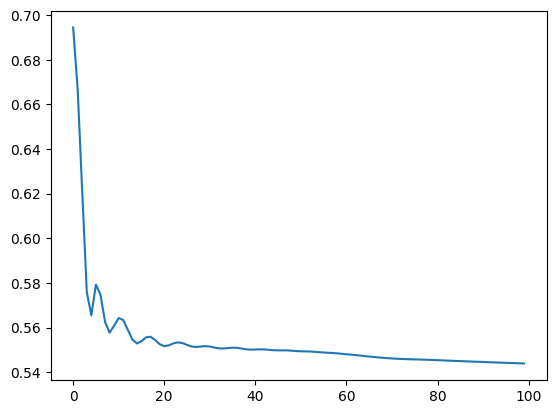

In [237]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [238]:
from sklearn.metrics import f1_score
import numpy as np
def print_eval(y_pred):
    micro_f1 = f1_score(test_data.y, y_pred, average='micro')
    ratio_corr_labels = np.equal(test_data.y, y_pred).sum() / test_data.y.numel()
    print(f"F1-micro {str(micro_f1)} - Overall-Acc: {str(ratio_corr_labels)}")

In [239]:
evaluate(model, X_train, y_train)

tensor(0.5438, device='cuda:0')


In [240]:
with torch.inference_mode():
    model.eval()
    y_pred = torch.round(torch.sigmoid(model(X_test))).detach().cpu()
    print_eval(y_pred)

F1-micro 0.42403376881143023 - Overall-Acc: tensor(0.7465)
